In [1]:
# Import Dependencies

import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

## Loading Image Data

In [2]:
# Set the paths and dirs

path = " " # Your path to the data folder
dirs = os.listdir(path)[1:]

In [3]:
# Get image shape

print("Shape of the sample image is",end=" ")
cv2.imread(path + "/s1/1.pgm", 0).shape

Shape of the sample image is 

(112, 92)

In [4]:
def load_data(path, dir, split = 0.6):
    
    # This is a function to load the data into a given train-test split ratio
    # and return the training and testing set.

    # Input Parameters: 
    # path : Path of the directories
    # dirs : List of all the directories
    # split : The train-test split ratio

    # Output:
    # train : Traning set
    # test : Testing set
    
    train = {"image":[], "class":[]}
    test = {"image":[], "class":[]}
    classes = []

    print("Loading images...")

    for dir in tqdm(dirs):
        path_temp = path + "/" + dir
        imgs_name = os.listdir(path_temp)
        classes.append(int(dir[1:]))

        # training set
        for img_name in imgs_name[:int(len(imgs_name)*0.6)]:
            img = cv2.imread(path_temp + "/" + img_name, 0).flatten()
            train["image"].append(img)
            train["class"].append(int(dir[1:]))

        # test set
        for img_name in imgs_name[int(len(imgs_name)*0.6):]:
            img = cv2.imread(path_temp + "/" + img_name, 0).flatten()
            test["image"].append(img)
            test["class"].append(int(dir[1:]))

    train["image"] = np.array(train["image"])
    test["image"] = np.array(train["image"])

    return train,test,classes

In [5]:
train,test,classes = load_data(path, dir)

Loading images...


100%|██████████| 40/40 [00:01<00:00, 39.02it/s]


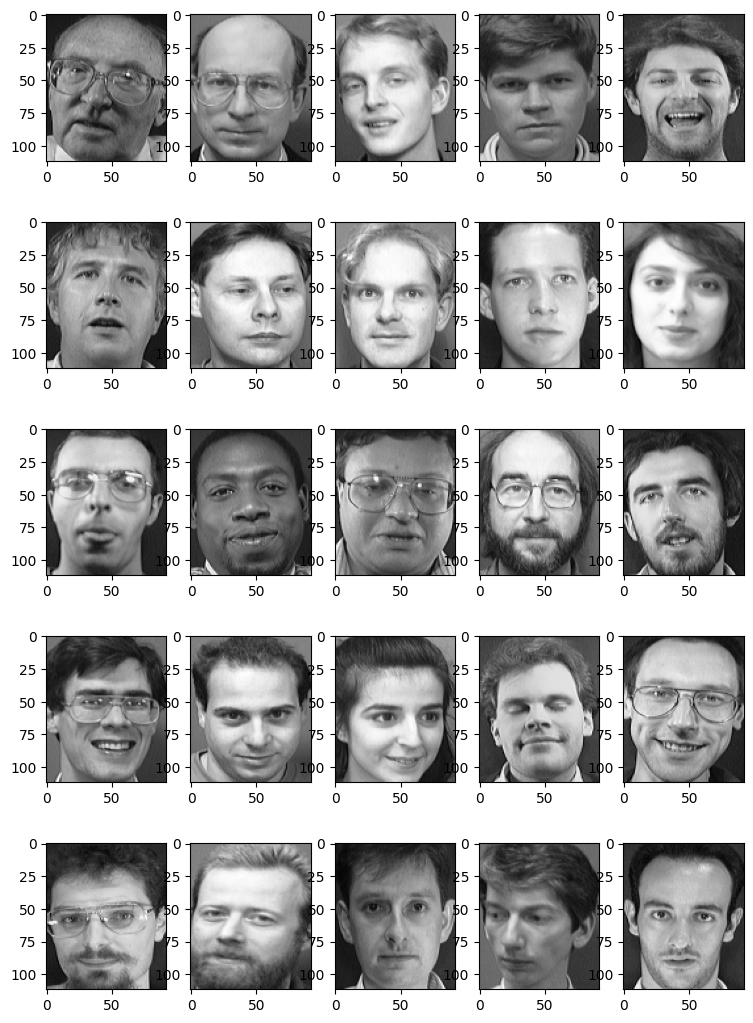

In [6]:
def plot_figures(imgs, w=119, h=92, columns=5, rows = 5):

    # imgs : List of images
    # w : width of the image
    # h : height of the image
    # columns : no. of columns of figures
    # rows : no. of rows of figures

    fig = plt.figure(figsize=(9, 13))

    xs = np.linspace(0, 2*np.pi, 60)  
    ys = np.abs(np.sin(xs)) 

    ax = []
    for i in range(columns*rows):
        img = imgs[i]
        ax.append( fig.add_subplot(rows, columns, i+1) )
        plt.imshow(img, cmap="gray")

    plt.show() 

imgs = []
for i in range(0, len(train["image"]), 6):
    imgs.append(train["image"][i].reshape(112,92))
plot_figures(imgs[:25])

## Training

In [7]:
# Subtract mean face from each face image

mean = np.mean(train["image"].T, axis=1).reshape((1,10304))
train_new = train["image"] - mean

cov = np.dot(train_new, train_new.T)
cov.shape

(240, 240)

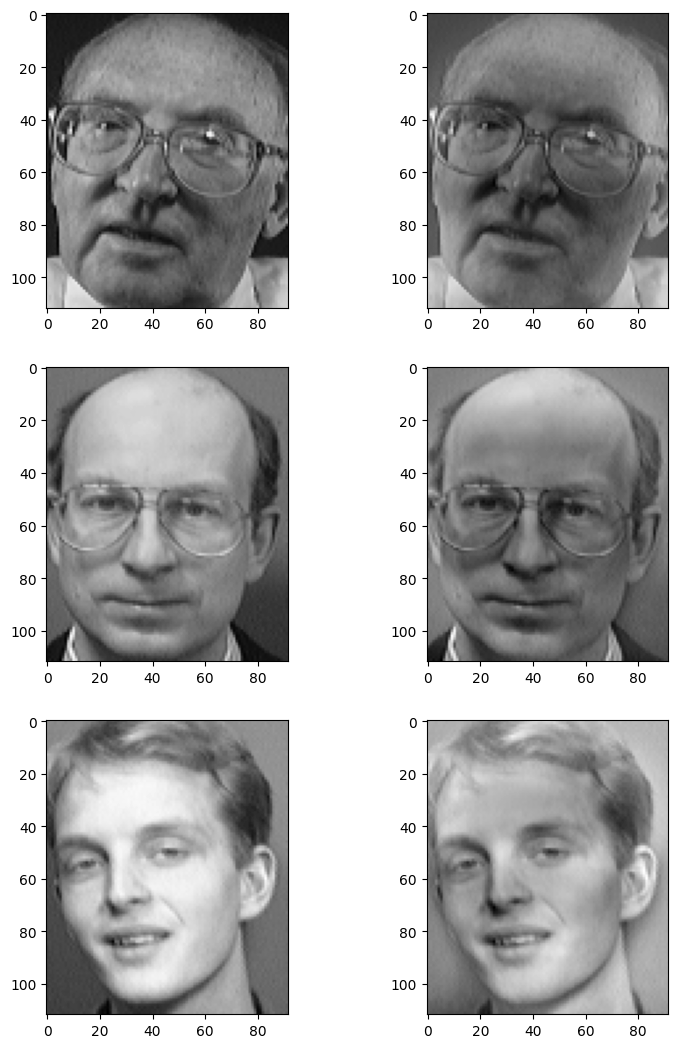

In [8]:
# Display original vs new image

imgs = []
imgs.append(train["image"][0].reshape(112,92))
imgs.append(train_new[0].reshape(112,92))
imgs.append(train["image"][6].reshape(112,92))
imgs.append(train_new[6].reshape(112,92))
imgs.append(train["image"][12].reshape(112,92))
imgs.append(train_new[12].reshape(112,92))

plot_figures(imgs, columns=2, rows = 3)

In [9]:
# Find the eigenvalues and eigenvectors of the covarience matrix 
# and sort the eigenvectors according to the eigenvalues

eigenValues, eigenVectors = np.linalg.eig(cov)

index = eigenValues.argsort()
eigenValues = eigenValues[index]
eigenVectors = eigenVectors[index]

In [10]:
# Generating eigenfaces and eigensignatures

k = 100
eigenFaces = np.dot(eigenVectors[:k], train_new)
signatures = np.dot(eigenFaces, train_new.T)

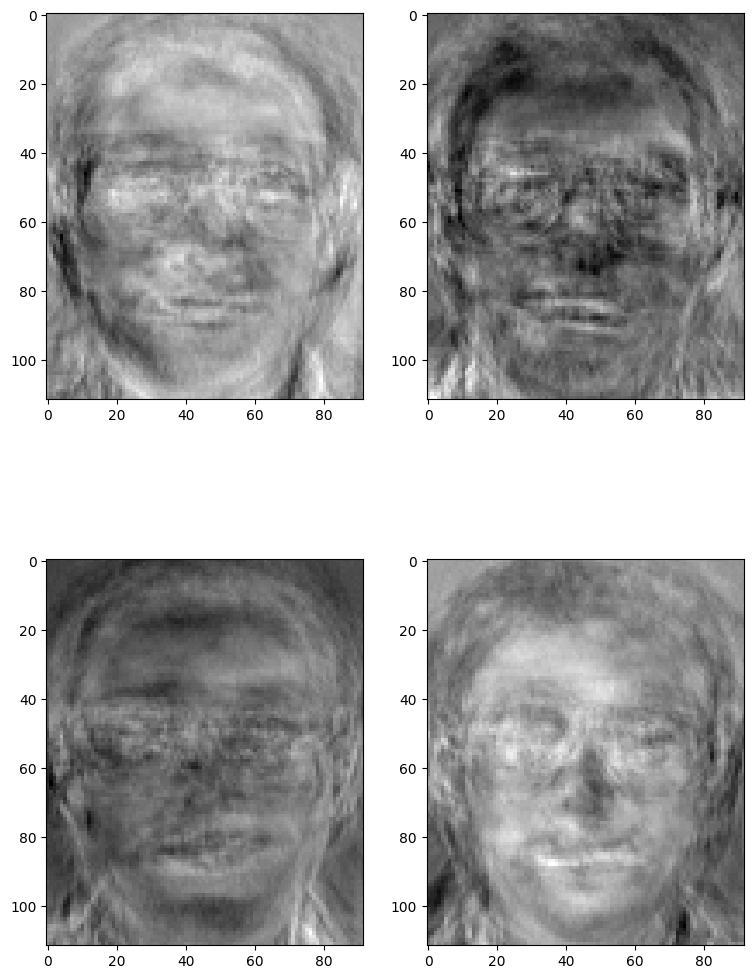

In [11]:
# Displaying some eigenfaces

imgs = []
imgs.append(eigenFaces[0].reshape(112,92))
imgs.append(eigenFaces[6].reshape(112,92))
imgs.append(eigenFaces[12].reshape(112,92))
imgs.append(eigenFaces[18].reshape(112,92))

plot_figures(imgs, columns=2, rows = 2)

## Testing

In [12]:
def predict(img, mean = mean, eigenFaces = eigenFaces, signatures = signatures, classes = classes):

    # img : input image of shape (10304,)
  
    img = (img - mean).reshape((10304,))
    img = np.dot(eigenFaces, img)

    y_hat = []
    for i in tqdm(range(240)):
        temp = np.linalg.norm((img - signatures.T[i]) ** 2)
        y_hat.append(temp)

    return classes[y_hat.index(min(y_hat)) // 4]

In [13]:
# Test the system

i = 6
y_hat = predict(test["image"][i])
print("\n\nOriginal Class: {}\nPredicted Class: {}".format(test["class"][i], y_hat))

100%|██████████| 240/240 [00:00<00:00, 74803.67it/s]



Original Class: 13
Predicted Class: 13
